In [1]:
import os
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from sklearn import neural_network
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from math import exp
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import warnings
import random
import math

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in square")
warnings.filterwarnings("ignore", message="Got `batch_size` less than 1 or larger than sample size", category=UserWarning)

In [3]:
def loadImages(image_dir):
    data = dict()
    data['label'] = []
    data['filname'] = []
    data['data'] = []

    for file in os.listdir(image_dir):
        if file[-3:] in {'jpg'}:
            im = imread(os.path.join(image_dir, file))
            im = resize(im, (100, 100))
            data['filname'].append(file)
            data['data'].append(im)
            if 'sepia' in file:
                data['label'].append('sepia')
            else:
                data['label'].append('normal')
    return data['data'], data['label']


#image_dir = "data/normal_sepia"
#inputs, outputs = loadImages(image_dir)

In [4]:
def flatten(xs):
    result = []
    for x in xs:
        y = []
        for line in x:
            for el in line:
                y.append(el)
        result.append(y)
    return result

In [5]:
def transform(images):
    transformed = []
    for image in images:
        img = []
        for i in range(len(image)):
            line = []
            for j in range(len(image[0])):
                pixel = image[i][j]
                pixel *= 255
                color = int(pixel[0]) << 16 + int(pixel[1]) << 8 + int(pixel[2])
                line.append(color / 255)
            img.append(line)
        transformed.append(img)

    return flatten(transformed)

In [6]:
def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    testSample = [i for i in indexes if i not in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]

    return trainInputs, trainOutputs, testInputs, testOutputs

In [7]:
def evalMultiClass(realLabels, computedLabels, labelsNames):
    confMatrix = confusion_matrix(realLabels, computedLabels)
    acc = sum([confMatrix[i][i] for i in range(len(labelsNames))]) / len(realLabels)
    prec = {}
    recall = {}
    for i in range(len(labelsNames)):
        if sum([confMatrix[j][i] for j in range(len(labelsNames))]) != 0:
            prec[labelsNames[i]] = confMatrix[i][i] / sum([confMatrix[j][i] for j in range(len(labelsNames))])
        else:
            prec[labelsNames[i]] = 0
        
        if sum([confMatrix[i][j] for j in range(len(labelsNames))]) != 0:
            recall[labelsNames[i]] = confMatrix[i][i] / sum([confMatrix[i][j] for j in range(len(labelsNames))])
        else:
            recall[labelsNames[i]] = 0
            
    return acc, prec, recall, confMatrix

In [8]:
def plotConfusionMatrix(cm, classNames, title):
    import itertools
    classes= classNames
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tickMarks = np.arange(len(classNames))
    plt.xticks(tickMarks, classNames, rotation=45)
    plt.yticks(tickMarks, classNames)

    textFormat = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], textFormat),
                 horizontalalignment='center',
                 color='white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

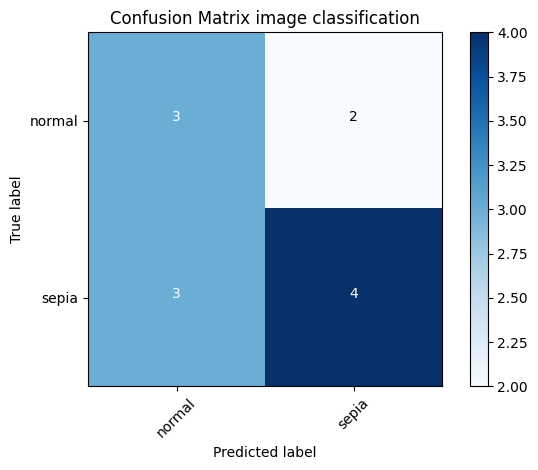

Acc:  0.5833333333333334
Precision:  {'normal': 0.5, 'sepia': 0.6666666666666666}
Recall:  {'normal': 0.6, 'sepia': 0.5714285714285714}


In [9]:
def ann_classification(inputs, outputs):
    trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

    trainInputs = transform(trainInputs)
    testInputs = transform(testInputs)

    classifier = neural_network.MLPClassifier()

    classifier.fit(trainInputs, trainOutputs)
    predictedOutputs = classifier.predict(testInputs)

    acc, precision, recall, cm = evalMultiClass(np.array(testOutputs), predictedOutputs, ['normal', 'sepia'])
    plotConfusionMatrix(cm, ['normal', 'sepia'], "image classification")

    print("Acc: ", acc)
    print("Precision: ", precision)
    print("Recall: ", recall)


image_dir = "data/normal_sepia"
inputs, outputs = loadImages(image_dir)
ann_classification(inputs, outputs)

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
Best accuracy: 0.8333333333333334


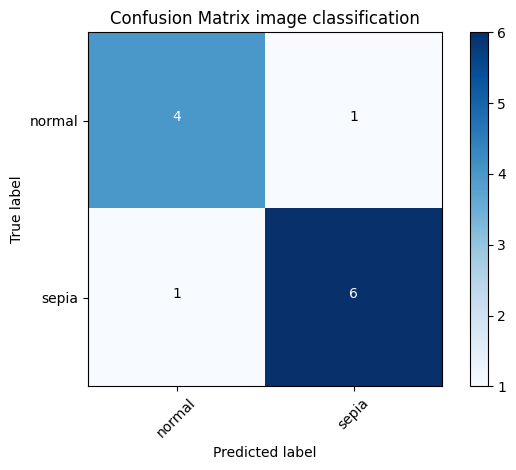

In [10]:
def softmax_classification(inputs, outputs, param_grid):
    trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

    trainInputs = transform(trainInputs)
    testInputs = transform(testInputs)

    best_accuracy = 0
    best_params = None
    best_cm = None

    for params in ParameterGrid(param_grid):
        hidden_layer_sizes = params['hidden_layer_sizes']
        activation = params['activation']
        learning_rate_init = params['learning_rate_init']
        alpha = params['alpha']
        batch_size = params['batch_size']

        # Define a Softmax classifier with current hyperparameters
        classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                                   learning_rate_init=learning_rate_init, alpha=alpha, batch_size=batch_size,
                                   max_iter=1000, random_state=42)

        classifier.fit(trainInputs, trainOutputs)
        predictedOutputs = classifier.predict(testInputs)

        acc, _, _, cm = evalMultiClass(np.array(testOutputs), predictedOutputs, ['normal', 'sepia'])

        # Keep track of the best parameters, accuracy, and confusion matrix
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = params
            best_cm = cm

    # Print best parameters and accuracy
    print("Best parameters:", best_params)
    print("Best accuracy:", best_accuracy)

    # Plot confusion matrix for the best performing classifier
    plotConfusionMatrix(best_cm, ['normal', 'sepia'], "image classification")


image_dir = "data/normal_sepia"
inputs, outputs = loadImages(image_dir)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter (λ)
    'batch_size': [32, 64, 128]  # Mini-batch size
}

softmax_classification(inputs, outputs, param_grid)

In [73]:
class Layer:
    def __init__(self, number_of_inputs_per_neuron, number_of_neurons, func):
        self.weights = [[2 * random.random() - 1 for _ in range(number_of_neurons)] for _ in range(number_of_inputs_per_neuron)]
        self.func = func


class Network:
    def __init__(self):
        self.layers = []
        self.inputs = []
        self.outputs = []
        self.error_per_layer = []
        self.deltas = []

    def add_layer(self, layer):
        self.layers.append(layer)
        self.inputs.append(None)
        self.outputs.append(None)
        self.error_per_layer.append(None)
        self.deltas.append(None)

    def fit(self, x_train, y_train, epochs=1000, learning_rate=0.05):
        ep = []
        errors = []
        self.inputs[0] = x_train
        for epoch in range(epochs):
            self.forward_propagation()
    
            net_output = self.outputs[-1]
            self.error_per_layer[-1] = [float(a) - b for a, b in zip(y_train, net_output)]
    
            self.backward_propagation()
            self.update_weights(learning_rate)
    
            ep.append(epoch)
            errors.append(self.compute_error(net_output, y_train))
    
        plt.scatter(ep, errors, s=1)
        plt.show()

    def compute_error(self, output, real):
        sum_error = 0
        for i in range(len(real)):
            for j in range(len(real[i])):
                sum_error -= real[i][j] * math.log(output[i][j])
        sum_error /= len(real)
        return sum_error

    def update_weights(self, learning_rate):
        for i in range(len(self.layers)):
            adjustment = [[0 for _ in range(len(self.layers[i].weights[0]))] for _ in range(len(self.layers[i].weights))]
            for j in range(len(self.inputs[i])):
                for k in range(len(self.deltas[i])):
                    adjustment[j][k] = learning_rate * self.inputs[i][j] * self.deltas[i][k]
            self.layers[i].weights = [[self.layers[i].weights[j][k] + adjustment[j][k] for k in range(len(adjustment[j]))] 
                                      for j in range(len(adjustment))]

    def forward_propagation(self):
        for i in range(len(self.layers)):
            if i != 0:
                self.inputs[i] = self.outputs[i - 1]
            self.outputs[i] = []
            for j in range(len(self.layers[i].weights[0])):
                weighted_sum = 0
                for k in range(len(self.inputs[i])):
                    weighted_sum += self.inputs[i][k] * self.layers[i].weights[k][j]
                self.outputs[i].append(self.layers[i].func(weighted_sum))

    def backward_propagation(self):
        for i in range(len(self.layers) - 1, -1, -1):
            self.deltas[i] = []
            if i != len(self.layers) - 1:
                for j in range(len(self.layers[i + 1].weights[0])):
                    delta = 0
                    for k in range(len(self.deltas[i + 1])):
                        delta += self.deltas[i + 1][k] * self.layers[i + 1].weights[j][k]
                    self.deltas[i].append(delta)
            for j in range(len(self.outputs[i])):
                self.deltas[i][j] = self.error_per_layer[i][j] * self.layers[i].func(self.outputs[i][j], der=True)

    def predict(self, x_test):
        self.inputs[0] = x_test
        self.forward_propagation()
        return self.outputs[-1]

In [37]:
def sigmoid(x, der=False):
    if not der:
        return 1 / (1 + np.exp(-x))
    else:
        return x * (1 - x)

def transformOutputs(outputs):
    rez = []
    for output in outputs:
        if output == 'normal':
            rez.append(1)
        else:
            rez.append(0)
    return rez